In [1]:
# tratamiento de los datos
# ============================================
import pandas as pd
import numpy as np

# librerías para la visualización de los datos
# ============================================
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer tamaño fijo de gráficas
# ==================================
plt.rcParams["figure.figsize"] = (10,8)

# Configuración warnings
# ======================
import warnings
warnings.filterwarnings('ignore')

# Pair Programming Intro Machine Learning

Empezamos una nueva lección, y este es el momento de poner en práctica los conocimientos adquiridos sobre la Regresión Lineal Simple I. 

Para ello os vamos a pedir que por vuestra cuenta busqueis un dataset que os guste, por ejemplo de Kaggle o de donde queráis extraerlo. 

De forma que vamos a probar a realizar **ajustes lineales** con el fin de predecir alguna de sus **variables**. 
Este dataset será el que iremos usando a lo largo de todas las sesiones de pairprogramming de regresión lineal.

Se ruega a la hora de realizar la entrega que incluyais el conjunto de datos que hayais decidido emplear para estos ejercicios.

# Objetivos

Los objetivos de hoy son:

- Buscar un conjunto de datos a analizar:

- Es necesario que el conjunto de datos a analizar tenga variables **numéricas** y **categóricas**, primando que haya más de una variable de tipo numérico.
- Ya que tambien se utilizarán serán útiles a la hora de realizar predicciones en las clases de regresión lineal múltiple. Así mismo se recomienda que los datasets esten **ligeramente limpios** para facilitar los análisis.
- Explicar los **datos** y las **variables** disponibles en el conjunto de datos seleccionado:
- Esto se hace para que **comprendais** mejor los datos con los que estais trabajando.
- Realizar un **EDA** sencillo para la variable **dependiente** y la variable **independiente**.

In [48]:
df = pd.read_csv("data/00-insurance.csv", index_col = 0)
df.head(2)

,sex,bmi,children,smoker,region,charges
age,,,,,,
19,female,27.90,0,yes,southwest,16884.9240
18,male,33.77,1,no,southeast,1725.5523


## Entender las variables que tenemos y como es nuetro dataframe. 

In [4]:
# número de filas y columnas del dataframe

df.shape

(1338, 6)

In [5]:
# información general del dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 19 to 61
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sex       1338 non-null   object 
 1   bmi       1338 non-null   float64
 2   children  1338 non-null   int64  
 3   smoker    1338 non-null   object 
 4   region    1338 non-null   object 
 5   charges   1338 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 73.2+ KB


In [6]:
# nombre de las columnas de nuestro dataframe

df.columns

Index(['sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [7]:
# principales estadísticos de las columnas numéricas. recordemos que por defecto el describe nos devuelve las numéricas

df.describe().T

,count,mean,std,min,25%,50%,75%,max
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [8]:
# principales estadisticos de las variables categóricas

df.describe(include ="object").T

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364


In [9]:
# valores nulos en el dataframe

df.isnull().sum()

sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [10]:
# duplicados 

df.duplicated().sum()

1

In [36]:
df[df.duplicated()== True] # Para ver la fila duplicada

,sex,bmi,children,smoker,region,charges
age,,,,,,
19,male,30.59,0,no,northwest,1639.5631


In [37]:
df.drop_duplicates(inplace=True)

In [39]:
df.duplicated().sum()

0

Outliers

In [47]:
numericas = df.select_dtypes(include=['int64', 'float64'])
numericas.head(2)

,bmi,children,charges
age,,,
19,27.90,0,16884.9240
18,33.77,1,1725.5523


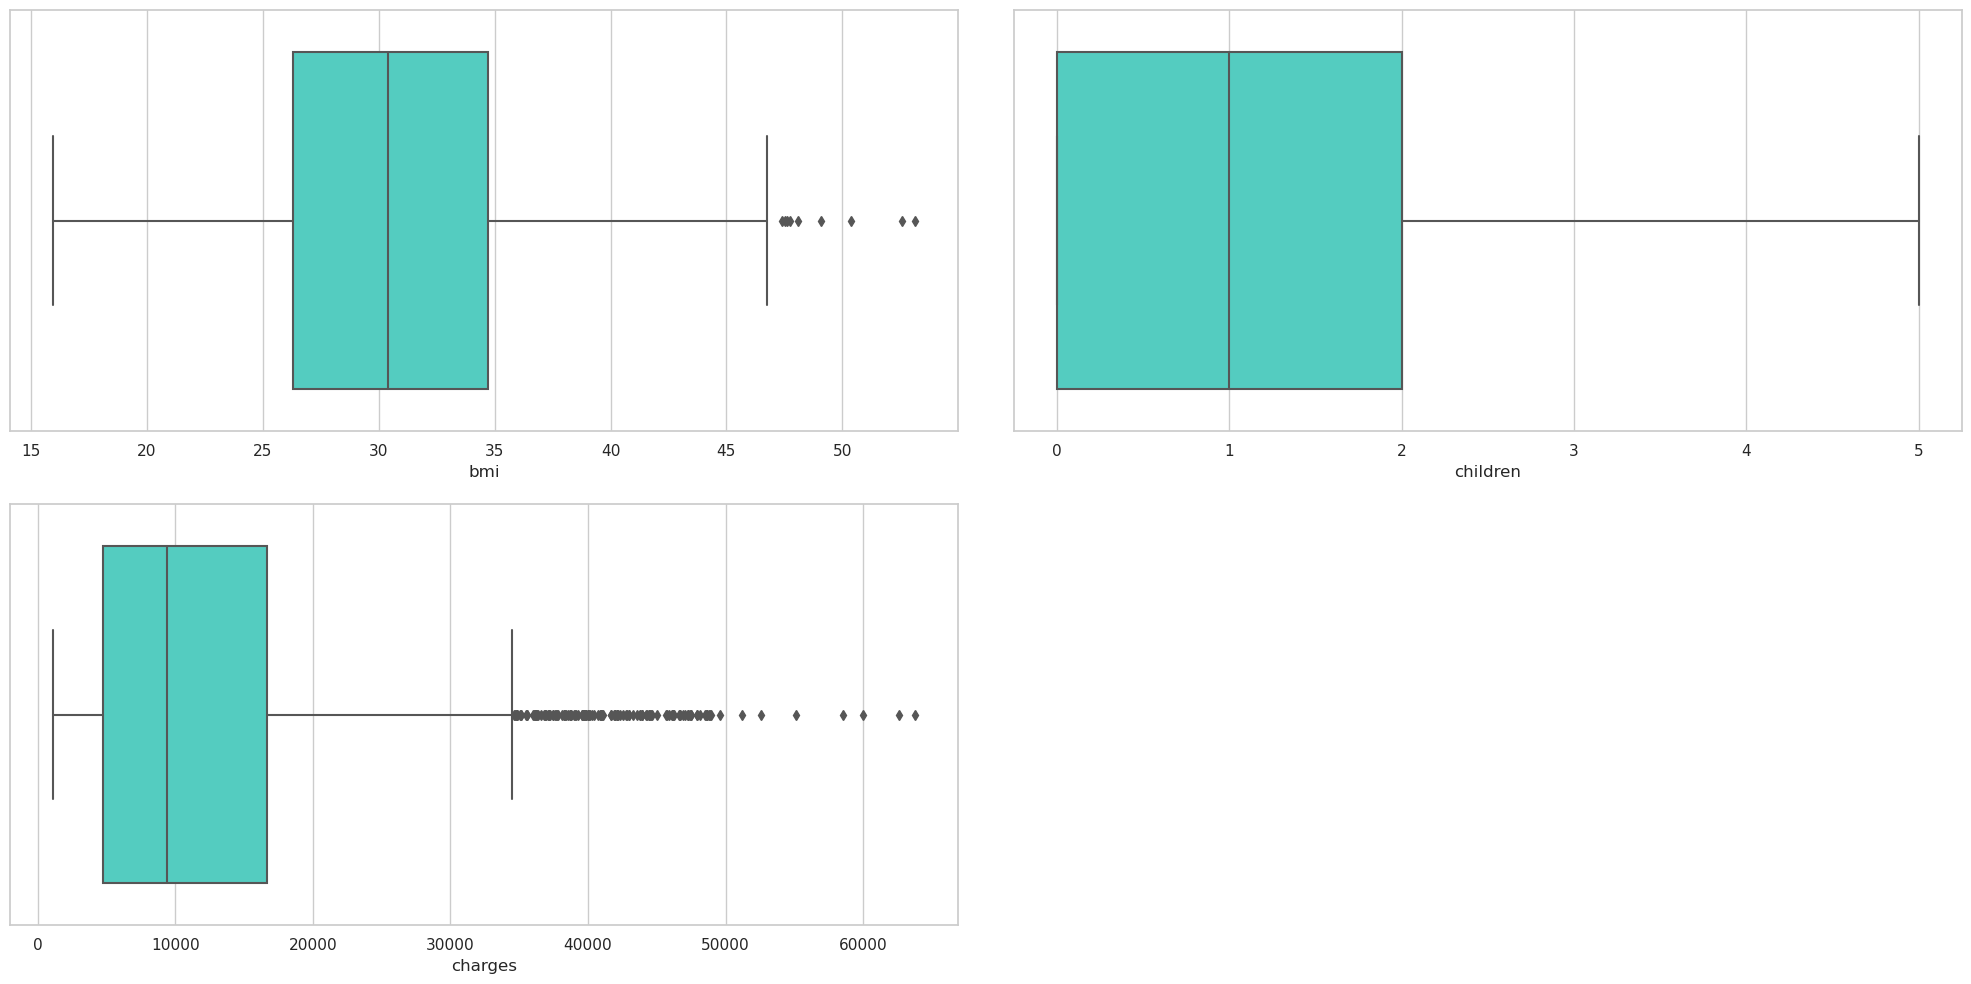

In [50]:
fig, axes = plt.subplots(2,2, figsize=(20,10))

axes = axes.flat

for indice, columna in enumerate(numericas.columns):
    sns.boxplot(x = numericas[columna], data = df, ax=axes[indice], color = "turquoise"); # para trazar una línea de densidad

    
plt.tight_layout()

fig.delaxes(axes[-1])

plt.show();

Como hemos visto que los boxplot tienen muchos outlier, vemos las distribuciones para ver si tenemos que decidir el tratamiento.

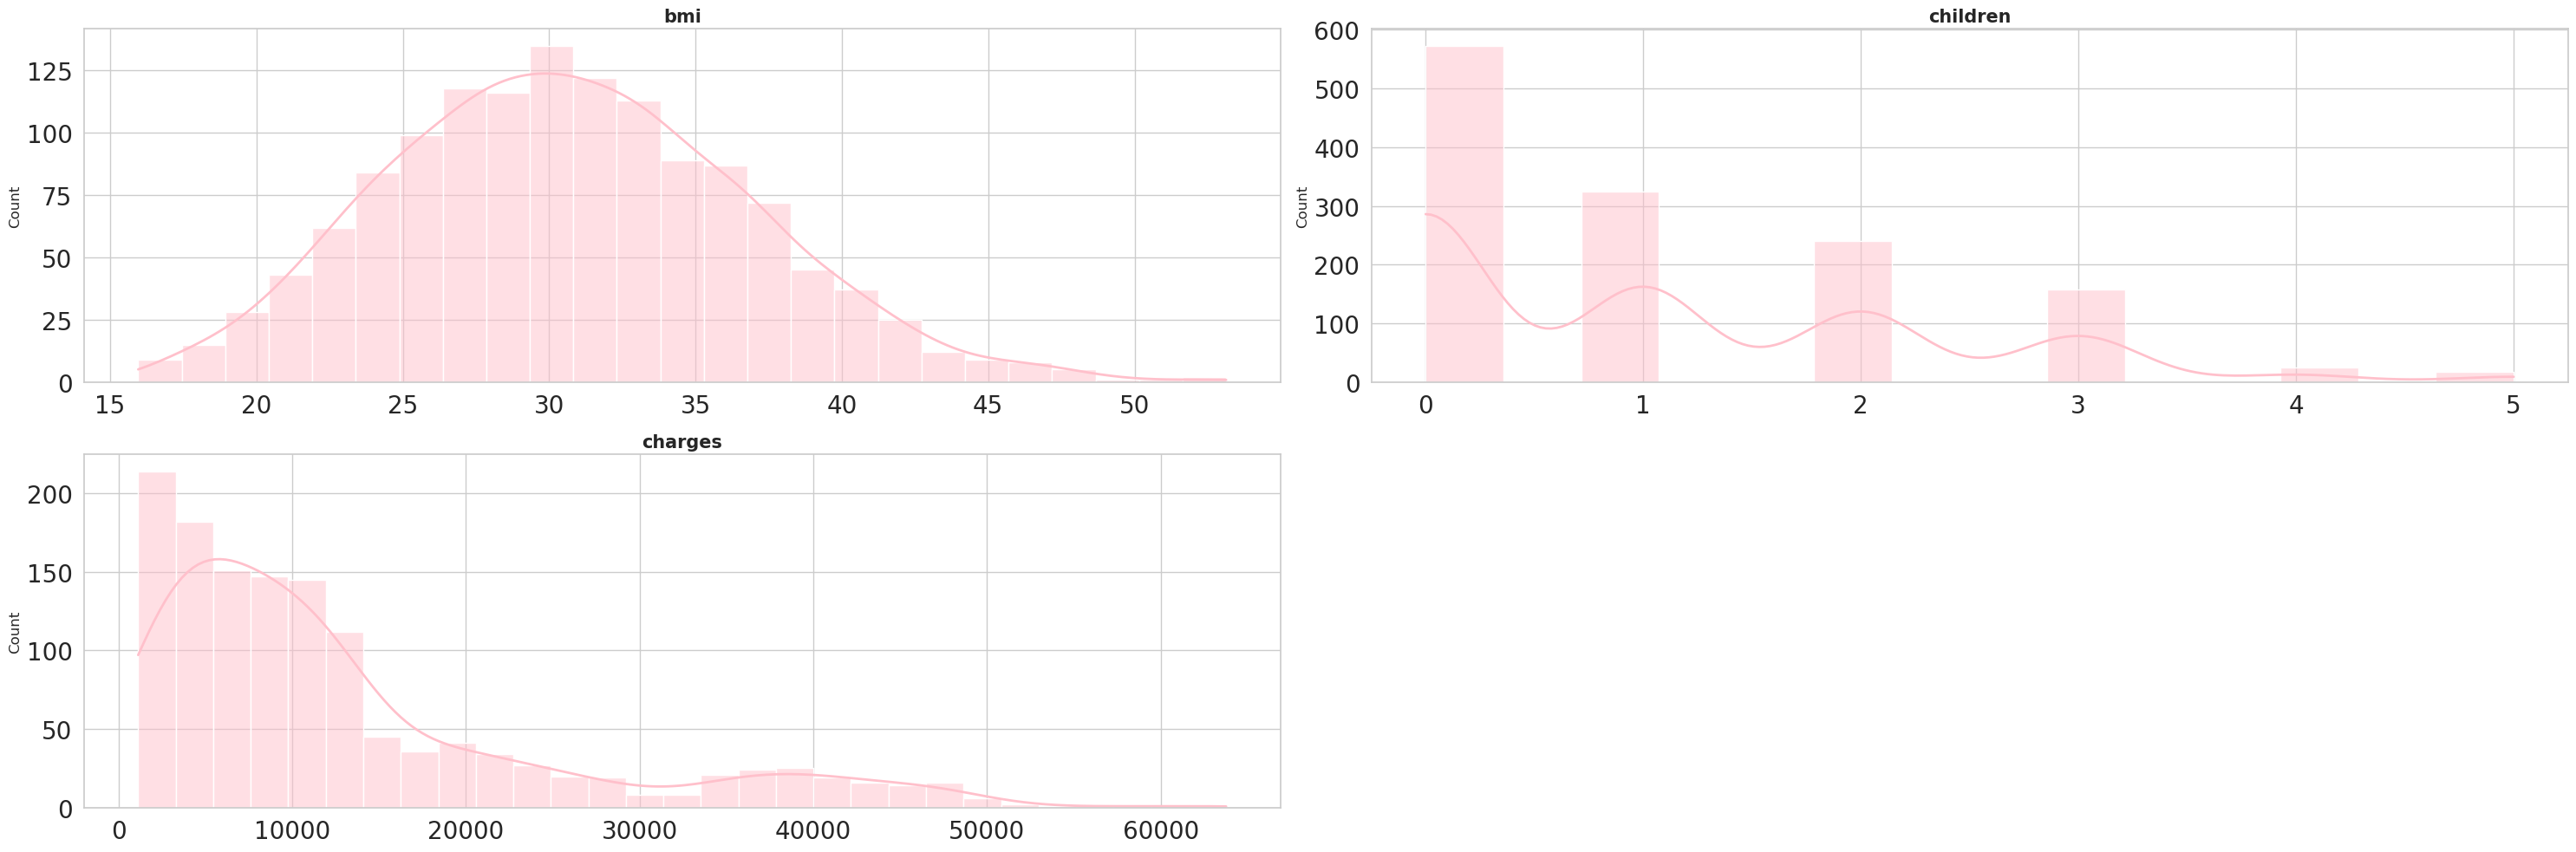

In [85]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 10))


axes = axes.flat#iterador


for i, colum in enumerate(numericas.columns): 
    sns.histplot(
        data = numericas[colum],
        kde = True,
        color = "pink", 
        line_kws = {"linewidth": 2}, # para indicar el ancho de las líneas de las barras
        alpha = 0.5, # para especificar la transparencia del color
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")

fig.tight_layout()
fig.delaxes(axes[-1]);


Detectar valores de los outliers

In [42]:
def detectar_outliers(lista_columnas, dataframe): 
    
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
        

    
    return dicc_indices 

In [43]:
lista_columnas = list(numericas.columns)
ind = detectar_outliers(lista_columnas, df)

In [44]:
# en que columnas nos hemos encontrado con nulos? 
ind.keys()

dict_keys(['bmi', 'charges'])

## Evaluar cuáles de las columnas tendremos que limpiar en nuestro *dataframe* y limpiarlas. 

### Gestión de *outliers*

Lo primero que haremos será chequear de nuevo los principales estadísticos de nuestras columnas para decidir con que valor reemplazamos los *outliers* 

In [62]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [17]:
# hacemos un for loop para iterar por el diccionario y acceder a las columnas y filas 
# y reemplazar los valores por la media y mediana

# for k, v in ind.items():
   # median = df[k].median()
   # for i in v:
      #  df.loc[i,k] = median 

## Analizar las relaciones entre las variables. 

### Variable respuesta

In [19]:
df.head(2)

,sex,bmi,children,smoker,region,charges
age,,,,,,
19,female,27.90,0,yes,southwest,16884.9240
18,male,33.77,1,no,southeast,1725.5523


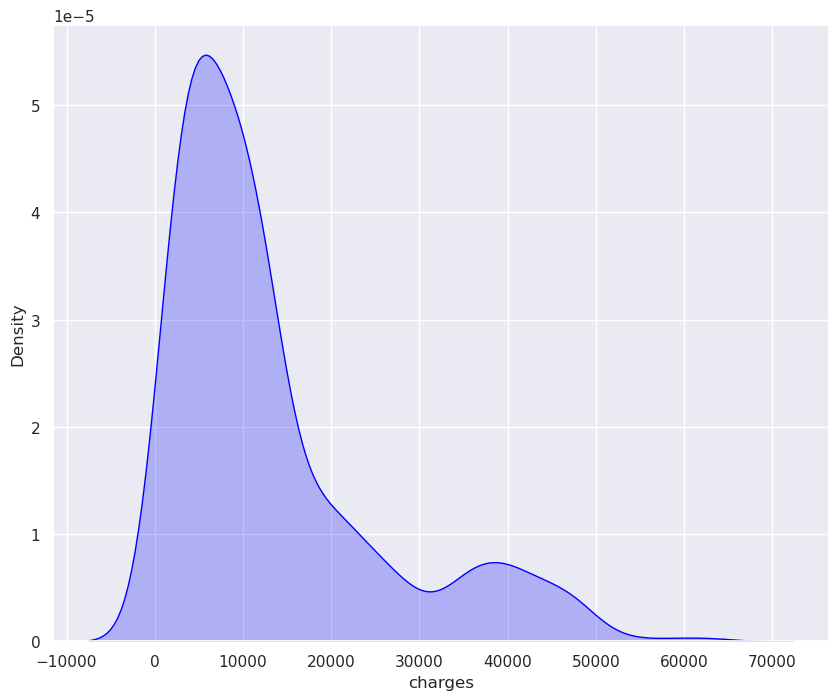

In [21]:
# vamos a ver visualmente como está distribuida la variable respuesta
sns.set(style="ticks")
sns.set_style("darkgrid")
sns.distplot(
    df["charges"], 
    hist = False, 
    color = "blue", 
    kde_kws = {"shade": True, "linewidth": 1});


### Variables predictoras

#### Variables numéricas

In [22]:
# exploramos cuáles son los principales estadísticos de las variables numéricas

df.select_dtypes(include = np.number).describe().T

,count,mean,std,min,25%,50%,75%,max
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


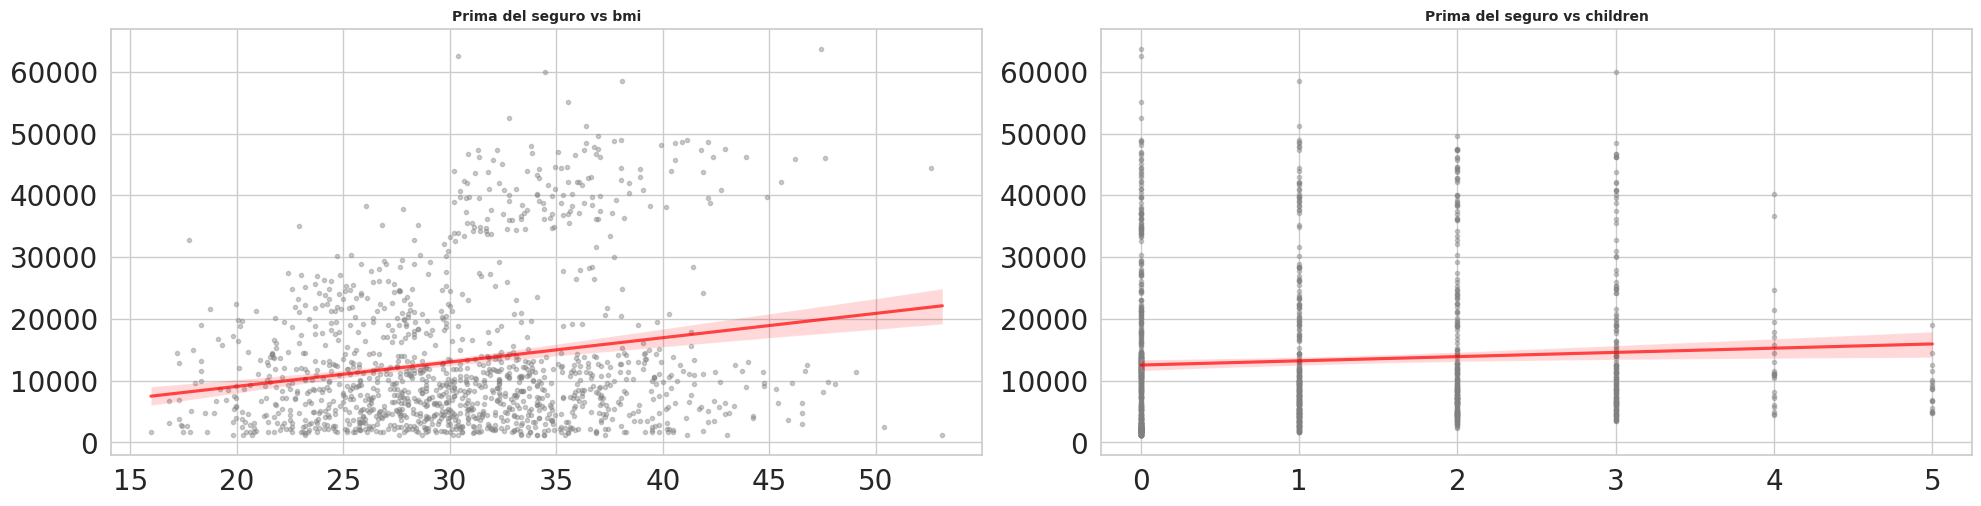

In [79]:
# Gráfico de relación entre variables predictoras y la variable a predecir
# ==============================================================================


fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (30, 10))


axes = axes.flat

columnas_numeric = df.select_dtypes(include = np.number).columns
columnas_numeric = columnas_numeric.drop("charges")

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x = df[colum], 
        y = df["charges"], 
        color = "gray", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Prima del seguro vs {colum}", fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
fig.tight_layout()
fig.delaxes(axes[-1])
fig.delaxes(axes[-2])
fig.delaxes(axes[-3])
fig.delaxes(axes[-4]);

#### Correlación entre variables numéricas

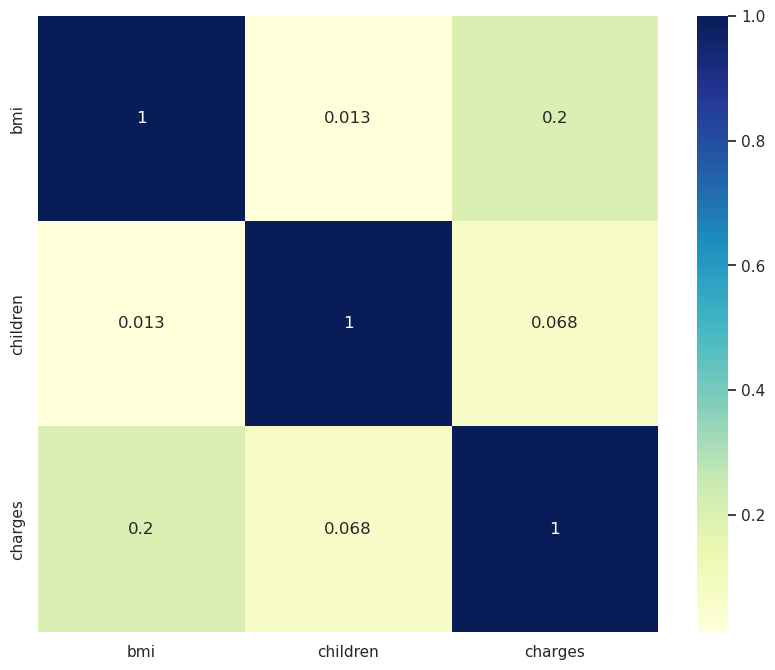

In [25]:
sns.heatmap(df.corr(), 
           cmap = "YlGnBu", 
           annot = True);

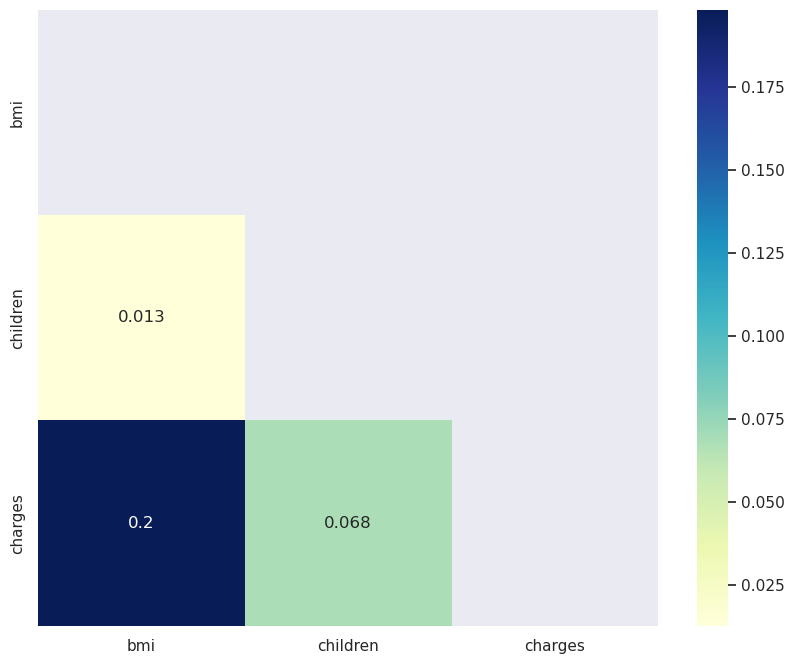

In [26]:
# creamos un dataframe todo de unos de la misma forma que nuestra matriz de correlación

mask = np.triu(np.ones_like(df.corr(), dtype = np.bool))

sns.heatmap(df.corr(), 
           cmap = "YlGnBu", 
            mask = mask,
           annot = True);

#### Variables categóricas

In [27]:
df.head(2)

,sex,bmi,children,smoker,region,charges
age,,,,,,
19,female,27.90,0,yes,southwest,16884.9240
18,male,33.77,1,no,southeast,1725.5523
